# Filtered Visualization of Damage Observations in Experimental Database 
This app helps experimental researchers explore and identify gaps in the nonstructural component test database. Users can visualize the distribution of tested component types, apply custom filters (component type, detail, material, size), and analyze the EDP levels at which damage was observed. The app includes both histogram plots and a summary table based on current filter selections. It is designed for fully interactive exploration—no coding required.

In [6]:
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import sqlite3
from IPython.display import display, clear_output
import base64
import io
from IPython.display import HTML
from IPython.display import FileLink
import re


In [7]:
# Connect to the SQLite database
conn = sqlite3.connect('../db.sqlite3')

# Read the 'ned_experiment' table
df = pd.read_sql_query("SELECT * FROM ned_app_experiment", conn)
df_component = pd.read_sql_query("SELECT * FROM ned_app_component", conn)
df_fragilitymodel = pd.read_sql_query("SELECT * FROM ned_app_fragilitymodel", conn)
df_fragilitycurve = pd.read_sql_query("SELECT * FROM ned_app_fragilitycurve", conn)

## Characterize Data
A categorical histogram of the number of datapoints available for each component type in the database is plotted.

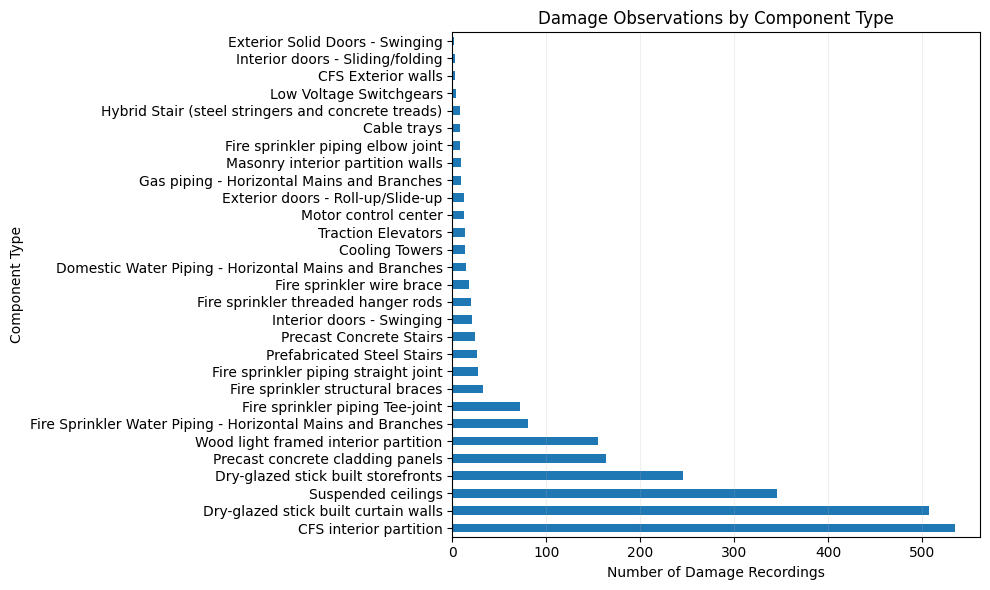

In [8]:
import matplotlib.pyplot as plt

current_selection = {
    'comptype': None,
    'edp': None,
    'detail': None,
    'material': None,
    'size': None
}


# Merge df (experiment) with all fields from df_component so component metadata is available
# Left-join on component_id; component table columns that collide will receive a "_comp" suffix.
df_merged = df.merge(
    df_component,
    left_on='component_id',
    right_on='component_id',
    how='left',
    suffixes=('', '_comp')
)

# Prefer the canonical component name from the component table when available
if 'name_comp' in df_merged.columns:
    df_merged['name'] = df_merged['name_comp'].combine_first(df_merged.get('name'))

# Optional: drop redundant helper columns if you want (uncomment to enable)
# df_merged = df_merged.drop(columns=[c for c in df_merged.columns if c.endswith('_comp') and c != 'name_comp'])

# Horizontal bar chart (x = counts, y = component name)
# Sort ascending then invert y so the largest ends up on top
counts = df_merged['name'].value_counts().sort_values(ascending=True)

ax = counts.plot.barh(title='Damage Observations by Component Type', figsize=(10, 6))
ax.set_xlabel("Number of Damage Recordings")
ax.set_ylabel("Component Type")
ax.invert_yaxis()  # largest at the top
ax.grid(axis='x', alpha=0.2)

plt.tight_layout()
plt.show()

# Update comp_types and edp_types from the merged frame
comp_types = df_merged['name'].dropna().unique()
edp_types = df_merged['edp_metric'].dropna().unique()


### Table of Filtered Damage Records
This table displays all individual damage records from the database that match the selected filters. Use the dropdowns to filter by component type, detail, material, and size. The table updates automatically when any filter changes. You can download filtered data as a CSV file by clicking "**Download CSV**."

In [9]:
# --- Component table with NistGroupelment filter (strict first-3-chars prefix) ---

# 2) NistGroupelment dropdown (same style you used before)
_ng = df_merged[['group']].dropna().copy()
_ng_opts = ["All"] + sorted(_ng['group'].unique().tolist())
nist_dropdown = widgets.Dropdown(options=_ng_opts, description="NistGroupelment", value="All")

# 3) Other dropdowns
# Initialize component dropdown from the component table (robust source of names)
_comp_names = sorted(df_merged['name'].dropna().unique().tolist())
comp_dropdown = widgets.Dropdown(options=["All"] + _comp_names, description="Component", value="All")
detail_dropdown = widgets.Dropdown(description="Detail")
material_dropdown = widgets.Dropdown(description="Material")
size_dropdown = widgets.Dropdown(description="Size")
page_slider = widgets.IntSlider(value=1, min=1, description='Page', step=1)

# Optional: align labels/widths like your other UI
LABEL_W = '180px'
FIELD_W = '520px'
for w in (nist_dropdown, comp_dropdown, detail_dropdown, material_dropdown, size_dropdown):
    w.style = {'description_width': LABEL_W}
    w.layout = widgets.Layout(width=FIELD_W)

# 4) Output + state
table_output = widgets.Output(layout=widgets.Layout(overflow='auto', max_height='400px', border='1px solid #ddd'))
filtered_df_global = pd.DataFrame()

# 5) Component list refresh based on NistGroupelment
def refresh_comp_options(change=None):
    selected_group = nist_dropdown.value  # e.g., "B10" or "All"

    # Filter df_component by the selected group (exact match on 'group' field)
    if selected_group is None or selected_group == "All":
        filtered_components = df_component.copy()
    else:
        # normalize and match strings to be robust to whitespace/case
        filtered_components = df_component[
            df_component['group'].astype(str).str.strip().str.upper() ==
            str(selected_group).strip().upper()
        ].copy()

    # Build available component name list from the filtered component rows
    avail_names = sorted(filtered_components['name'].dropna().unique().tolist())

    # If none found, fall back to showing all component names (prevents empty dropdown)
    if not avail_names:
        avail_names = sorted(df_component['name'].dropna().unique().tolist())

    avail_opts = ["All"] + avail_names

    # Preserve current selection where possible, else choose "All"
    current_value = comp_dropdown.value if comp_dropdown.value in avail_opts else "All"
    comp_dropdown.options = avail_opts
    comp_dropdown.value = current_value

    update_filter_options()
    show_paginated_table()

# 6) Update filter choices for detail/material/size after component or group changes
def update_filter_options(*args):
    # Respect both group and component in the options
    sub = df_merged.copy()

    if nist_dropdown.value and nist_dropdown.value != "All":
        sub = sub[sub['group'] == nist_dropdown.value]

    # Only apply component filter when a concrete component is selected (not "All")
    if comp_dropdown.value and comp_dropdown.value != "All":
        sub = sub[sub['name'] == comp_dropdown.value]

    # If no rows, keep dropdowns valid
    if sub.empty:
        detail_dropdown.options = ["All"];  detail_dropdown.value = "All"
        material_dropdown.options = ["All"]; material_dropdown.value = "All"
        size_dropdown.options = ["All"];     size_dropdown.value = "All"
        return

    detail_dropdown.options = ["All"] + sorted(sub['comp_detail'].dropna().unique())
    material_dropdown.options = ["All"] + sorted(sub['material'].dropna().unique())
    size_dropdown.options = ["All"] + sorted(sub['size_class'].dropna().unique())
    detail_dropdown.value = "All"
    material_dropdown.value = "All"
    size_dropdown.value = "All"

# 7) Data filter (table/download) — apply Nist group first, then component & others
def filter_data(full=False):
    base = df_merged.copy()

    # Only filter by component when a concrete selection (not "All")
    if nist_dropdown.value and nist_dropdown.value != "All":
        base = base[base['group'] == nist_dropdown.value]
    if comp_dropdown.value and comp_dropdown.value != "All":
        base = base[base['name'] == comp_dropdown.value]
    if detail_dropdown.value != "All":
        base = base[base['comp_detail'] == detail_dropdown.value]
    if material_dropdown.value != "All":
        base = base[base['material'] == material_dropdown.value]
    if size_dropdown.value != "All":
        base = base[base['size_class'] == size_dropdown.value]

    base = base.reset_index(drop=True)

    if not full:
        excluded_cols = [
            'loading_protocol', 'peak_test_amplitude', 'governing_design_standard',
            'prior_damage', 'prior_damage_repaired',
            'id', 'reviewer', 'comp_detail', 'material', 'size_class',
            'component_id', 'notes', 'specimen_inspection_sequence',
            'alt_edp_metric', 'alt_edp_unit', 'alt_edp_value',
            'reference_id', 'id_comp', 'element', 'group', 'major_group', 'subelement',
            'id_x', 'id_y', 'name'  # hide internal helper
        ]
        display_cols = [c for c in base.columns if c not in excluded_cols]
        return base[display_cols]
    else:
        # Full dataset (for download), keep all columns
        return base

# 8) Table rendering (unchanged)
def show_paginated_table(change=None):
    global filtered_df_global
    filtered_df_global = filter_data()

    total_rows = filtered_df_global.shape[0]
    rows_per_page = 20
    total_pages = max(1, (total_rows + rows_per_page - 1) // rows_per_page)
    page_slider.max = total_pages

    if total_rows == 0:
        with table_output:
            clear_output()
            print("No matching records to display.")
        return

    start = (page_slider.value - 1) * rows_per_page
    end = start + rows_per_page
    page_df = filtered_df_global.iloc[start:end]

    html_table = page_df.to_html(index=False)
    html_table = html_table.replace(
        "<thead>",
        '<thead style="position: sticky; top: 0; background-color: white; z-index: 1;">'
    ).replace(
        "<th>",
        '<th style="position: sticky; top: 0; background-color: white; border-bottom: 1px solid #ccc; padding: 8px;">'
    )
    scrollable_html = f'''
    <div style="max-height: 350px; overflow: auto; border: 1px solid #ccc; padding: 4px;">
        <div style="min-width: 1000px;">{html_table}</div>
    </div>
    '''
    with table_output:
        clear_output()
        display(HTML(scrollable_html))

# 9) Download (unchanged, but uses full=True to include all cols)
download_button = widgets.Button(description="Download CSV")
def download_csv(b):
    df_full = filter_data(full=True)
    if not df_full.empty:
        csv_bytes = df_full.to_csv(index=False).encode()
        b64 = base64.b64encode(csv_bytes).decode()
        fname = "filtered_data.csv"
        link = f'<a download="{fname}" href="data:text/csv;base64,{b64}" target="_blank"><b>👉 Click here to download CSV</b></a>'
        with table_output:
            display(HTML(link))
download_button.on_click(download_csv)

# 10) Observers
comp_dropdown.observe(lambda change: show_paginated_table(), names='value')
detail_dropdown.observe(lambda change: show_paginated_table(), names='value')
material_dropdown.observe(lambda change: show_paginated_table(), names='value')
size_dropdown.observe(lambda change: show_paginated_table(), names='value')
page_slider.observe(show_paginated_table, names='value')
nist_dropdown.observe(refresh_comp_options, names='value')

# Initial sync & first render
refresh_comp_options()
show_paginated_table()

# 11) UI layout (add nist_dropdown at the top)
ui = widgets.VBox([
    nist_dropdown,
    comp_dropdown,
    detail_dropdown,
    material_dropdown,
    size_dropdown,
    page_slider,
    table_output,
    download_button
])
display(ui)


### Histogram of EDP Values
This histogram visualizes the distribution of EDP (Engineering Demand Parameter) values at which damage was recorded, based on the selected filters above. You can further refine the plot using the EDP and Damage State (DS Class) dropdowns. Each bar represents the frequency of damage records within a specific EDP range. The histogram updates automatically when the selected EDP or DS Class changes

In [10]:
# Output area for histogram
hist_output = widgets.Output()

# Dropdowns
edp_hist_dropdown = widgets.Dropdown(description="EDP")
ds_class_dropdown = widgets.Dropdown(description="DS Class")

# Update EDP and DS class options based on filters
def update_edp_hist_options(*args):
    df = df_merged[df_merged['name'] == comp_dropdown.value]
    if detail_dropdown.value != "All":
        df = df[df['comp_detail'] == detail_dropdown.value]
    if material_dropdown.value != "All":
        df = df[df['material'] == material_dropdown.value]
    if size_dropdown.value != "All":
        df = df[df['size_class'] == size_dropdown.value]

    # Update EDP options
    edp_values = sorted(df['edp_metric'].dropna().unique().tolist())
    if edp_values:
        prev_edp = edp_hist_dropdown.value
        edp_hist_dropdown.options = edp_values
        edp_hist_dropdown.value = prev_edp if prev_edp in edp_values else edp_values[0]
    else:
        edp_hist_dropdown.options = [""]
        edp_hist_dropdown.value = ""

    # Update DS class options
    ds_classes = sorted(df['ds_class'].dropna().unique().tolist())
    ds_class_dropdown.options = ["All"] + ds_classes
    if ds_class_dropdown.value not in ds_class_dropdown.options:
        ds_class_dropdown.value = "All"

    show_histogram()

# Plot histogram based on filters + selected EDP + DS class
def show_histogram(change=None):
    with hist_output:
        clear_output()
        df = df_merged[df_merged['name'] == comp_dropdown.value]
        if detail_dropdown.value != "All":
            df = df[df['comp_detail'] == detail_dropdown.value]
        if material_dropdown.value != "All":
            df = df[df['material'] == material_dropdown.value]
        if size_dropdown.value != "All":
            df = df[df['size_class'] == size_dropdown.value]
        df = df[df['edp_metric'] == edp_hist_dropdown.value]
        if ds_class_dropdown.value != "All":
            df = df[df['ds_class'] == ds_class_dropdown.value]

        edp_vals = pd.to_numeric(df['edp_value'], errors='coerce').dropna()

        if not edp_vals.empty:
            plt.figure(figsize=(6, 4))
            plt.hist(edp_vals, bins=10, color='skyblue', edgecolor='black')
            plt.title(f"Component Capacity Histogram (DS Class: {ds_class_dropdown.value})")
            plt.xlabel(edp_hist_dropdown.value)
            plt.ylabel("Frequency")
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()
        else:
            print("No matching numeric values for the current filters to plot.")
            

# Observers
comp_dropdown.observe(update_edp_hist_options, names='value')
detail_dropdown.observe(update_edp_hist_options, names='value')
material_dropdown.observe(update_edp_hist_options, names='value')
size_dropdown.observe(update_edp_hist_options, names='value')
edp_hist_dropdown.observe(show_histogram, names='value')
ds_class_dropdown.observe(show_histogram, names='value')

# Initial setup
update_edp_hist_options()

# Layout
hist_ui = widgets.VBox([
    edp_hist_dropdown,
    ds_class_dropdown,
    hist_output
])

display(hist_ui)